---
## 1. Setup and Data Loading

In [1]:
# ============================================
# IMPORT LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# ============================================
# LOAD PROCESSED DATA
# ============================================

df = pd.read_csv('../data/processed/features_temporal.csv')

print(f"✅ Loaded processed data: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"📅 Years: {df['Year'].min()} - {df['Year'].max()}")
print(f"🏫 Institutions: {df['UNITID'].nunique():,}")

✅ Loaded processed data: 12,054 rows × 20 columns
📅 Years: 2016 - 2022
🏫 Institutions: 1,722


In [3]:
# ============================================
# VERIFY DATA BY YEAR
# ============================================

print("📊 ROWS BY YEAR:")
print(df.groupby('Year').size())

📊 ROWS BY YEAR:
Year
2016    1722
2017    1722
2018    1722
2019    1722
2020    1722
2021    1722
2022    1722
dtype: int64


---
## 2. Define Split Boundaries

We split strictly by time to prevent any future data from leaking into training.

In [4]:
# ============================================
# TEMPORAL SPLIT CONFIGURATION
# ============================================

split_config = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                            TEMPORAL SPLIT PLAN                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  TRAINING SET: 2017-2019                                                     ║
║  ─────────────────────────                                                   ║
║  • Purpose: Learn patterns                                                   ║
║  • Years: 2017, 2018, 2019                                                   ║
║  • Expected: ~5,166 rows (1,722 × 3)                                         ║
║                                                                              ║
║  VALIDATION SET: 2020-2021                                                   ║
║  ────────────────────────────                                                ║
║  • Purpose: Tune hyperparameters                                             ║
║  • Years: 2020, 2021                                                         ║
║  • Expected: ~3,444 rows (1,722 × 2)                                         ║
║  • Note: Includes COVID years (may affect patterns)                          ║
║                                                                              ║
║  TEST SET: 2022                                                              ║
║  ─────────────────────                                                       ║
║  • Purpose: Final unbiased evaluation                                        ║
║  • Years: 2022                                                               ║
║  • Expected: ~1,722 rows                                                     ║
║  • NEVER used for training or tuning                                         ║
║                                                                              ║
║  FUTURE PREDICTION: 2023                                                     ║
║  ──────────────────────────                                                  ║
║  • Purpose: True predictions (no answers exist)                              ║
║  • Stored in: features_2023_predict.csv                                      ║
║  • Target column: N/A (would need 2024 data)                                 ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
"""

print(split_config)


╔══════════════════════════════════════════════════════════════════════════════╗
║                            TEMPORAL SPLIT PLAN                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  TRAINING SET: 2017-2019                                                     ║
║  ─────────────────────────                                                   ║
║  • Purpose: Learn patterns                                                   ║
║  • Years: 2017, 2018, 2019                                                   ║
║  • Expected: ~5,166 rows (1,722 × 3)                                         ║
║                                                                              ║
║  VALIDATION SET: 2020-2021                                                   ║
║  ────────────────────────────                                                ║
║  • Purpose: Tune hyperpar

---
## 3. Create Splits

In [5]:
# ============================================
# SPLIT BY YEAR
# ============================================

# Training: 2017-2019
train_years = [2017, 2018, 2019]
df_train = df[df['Year'].isin(train_years)].copy()

# Validation: 2020-2021
val_years = [2020, 2021]
df_val = df[df['Year'].isin(val_years)].copy()

# Test: 2022
test_years = [2022]
df_test = df[df['Year'].isin(test_years)].copy()

print("✅ TEMPORAL SPLITS CREATED:")
print(f"   Training (2017-2019): {len(df_train):,} rows")
print(f"   Validation (2020-2021): {len(df_val):,} rows")
print(f"   Test (2022): {len(df_test):,} rows")

✅ TEMPORAL SPLITS CREATED:
   Training (2017-2019): 5,166 rows
   Validation (2020-2021): 3,444 rows
   Test (2022): 1,722 rows


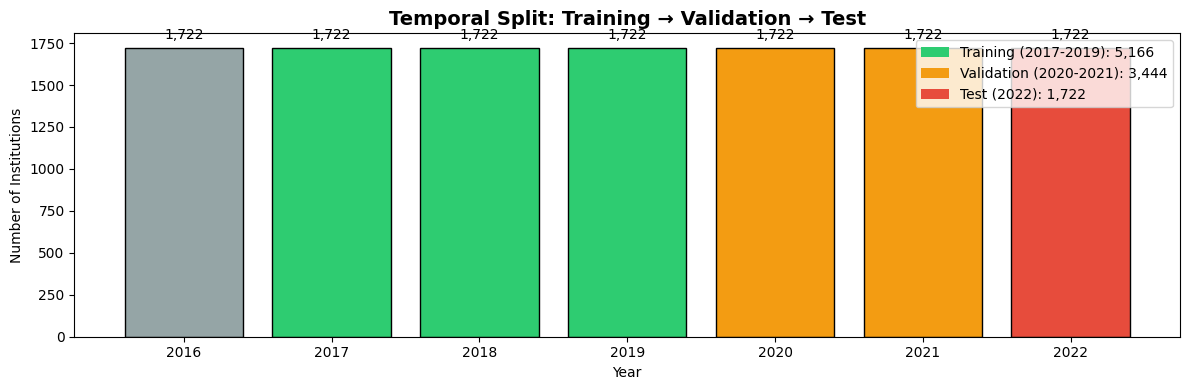


✅ Figure saved to ../reports/temporal_split.png


In [6]:
# ============================================
# VISUALIZE SPLIT
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

# Count by year
year_counts = df.groupby('Year').size()

# Define colors
colors = []
for year in year_counts.index:
    if year in train_years:
        colors.append('#2ecc71')  # Green for train
    elif year in val_years:
        colors.append('#f39c12')  # Orange for val
    elif year in test_years:
        colors.append('#e74c3c')  # Red for test
    else:
        colors.append('#95a5a6')  # Gray for other

bars = ax.bar(year_counts.index, year_counts.values, color=colors, edgecolor='black')

# Add labels on bars
for bar, count in zip(bars, year_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}', ha='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label=f'Training (2017-2019): {len(df_train):,}'),
    Patch(facecolor='#f39c12', label=f'Validation (2020-2021): {len(df_val):,}'),
    Patch(facecolor='#e74c3c', label=f'Test (2022): {len(df_test):,}')
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Institutions')
ax.set_title('Temporal Split: Training → Validation → Test', fontsize=14, fontweight='bold')
ax.set_xticks(year_counts.index)

plt.tight_layout()
plt.savefig('../reports/temporal_split.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to ../reports/temporal_split.png")

---
## 4. ⚠️ CRITICAL: Verify Temporal Integrity

We must confirm that no future data leaked into training.

In [7]:
# ============================================
# TEMPORAL INTEGRITY CHECK 1: Year Boundaries
# ============================================

print("🔍 TEMPORAL CHECK 1: Verifying year boundaries...")
print("="*60)

train_max_year = df_train['Year'].max()
val_min_year = df_val['Year'].min()
val_max_year = df_val['Year'].max()
test_min_year = df_test['Year'].min()

# Check that training ends before validation starts
if train_max_year < val_min_year:
    print(f"✅ PASS: Training ends ({train_max_year}) before validation starts ({val_min_year})")
else:
    print(f"❌ FAIL: Training overlaps with validation!")

# Check that validation ends before test starts
if val_max_year < test_min_year:
    print(f"✅ PASS: Validation ends ({val_max_year}) before test starts ({test_min_year})")
else:
    print(f"❌ FAIL: Validation overlaps with test!")

🔍 TEMPORAL CHECK 1: Verifying year boundaries...
✅ PASS: Training ends (2019) before validation starts (2020)
✅ PASS: Validation ends (2021) before test starts (2022)


In [8]:
# ============================================
# TEMPORAL INTEGRITY CHECK 2: No Overlap
# ============================================

print("\n🔍 TEMPORAL CHECK 2: Checking for row overlap...")
print("="*60)

# Create unique identifiers
train_ids = set(df_train['UNITID'].astype(str) + '_' + df_train['Year'].astype(str))
val_ids = set(df_val['UNITID'].astype(str) + '_' + df_val['Year'].astype(str))
test_ids = set(df_test['UNITID'].astype(str) + '_' + df_test['Year'].astype(str))

# Check overlaps
train_val_overlap = train_ids.intersection(val_ids)
train_test_overlap = train_ids.intersection(test_ids)
val_test_overlap = val_ids.intersection(test_ids)

if len(train_val_overlap) == 0:
    print("✅ PASS: No overlap between training and validation")
else:
    print(f"❌ FAIL: {len(train_val_overlap)} rows overlap between train and val!")

if len(train_test_overlap) == 0:
    print("✅ PASS: No overlap between training and test")
else:
    print(f"❌ FAIL: {len(train_test_overlap)} rows overlap between train and test!")

if len(val_test_overlap) == 0:
    print("✅ PASS: No overlap between validation and test")
else:
    print(f"❌ FAIL: {len(val_test_overlap)} rows overlap between val and test!")


🔍 TEMPORAL CHECK 2: Checking for row overlap...
✅ PASS: No overlap between training and validation
✅ PASS: No overlap between training and test
✅ PASS: No overlap between validation and test


In [9]:
# ============================================
# TEMPORAL INTEGRITY CHECK 3: Year Distribution
# ============================================

print("\n🔍 TEMPORAL CHECK 3: Confirming year distribution...")
print("="*60)

print("\nTRAINING SET YEARS:")
print(df_train.groupby('Year').size())

print("\nVALIDATION SET YEARS:")
print(df_val.groupby('Year').size())

print("\nTEST SET YEARS:")
print(df_test.groupby('Year').size())


🔍 TEMPORAL CHECK 3: Confirming year distribution...

TRAINING SET YEARS:
Year
2017    1722
2018    1722
2019    1722
dtype: int64

VALIDATION SET YEARS:
Year
2020    1722
2021    1722
dtype: int64

TEST SET YEARS:
Year
2022    1722
dtype: int64


In [10]:
# ============================================
# TEMPORAL INTEGRITY SUMMARY
# ============================================

print("\n" + "="*60)
print("📋 TEMPORAL INTEGRITY SUMMARY")
print("="*60)

all_checks_passed = (
    train_max_year < val_min_year and
    val_max_year < test_min_year and
    len(train_val_overlap) == 0 and
    len(train_test_overlap) == 0 and
    len(val_test_overlap) == 0
)

if all_checks_passed:
    print("\n✅ ALL TEMPORAL CHECKS PASSED!")
    print("\nData is properly split by time:")
    print("• Training uses ONLY past data (2017-2019)")
    print("• Validation uses ONLY future of training (2020-2021)")
    print("• Test uses ONLY future of validation (2022)")
    print("\nNo time travel is possible. Model will be honestly evaluated.")
else:
    print("\n❌ TEMPORAL CHECKS FAILED!")
    print("\nDO NOT proceed until issues are fixed.")


📋 TEMPORAL INTEGRITY SUMMARY

✅ ALL TEMPORAL CHECKS PASSED!

Data is properly split by time:
• Training uses ONLY past data (2017-2019)
• Validation uses ONLY future of training (2020-2021)
• Test uses ONLY future of validation (2022)

No time travel is possible. Model will be honestly evaluated.


---
## 5. Check Class Distribution Across Splits

In [11]:
# ============================================
# CLASS DISTRIBUTION BY SPLIT
# ============================================

print("📊 CLASS DISTRIBUTION ACROSS TEMPORAL SPLITS:")
print("="*60)

def show_class_dist(df_split, name):
    counts = df_split['Target_Trajectory'].value_counts()
    pcts = df_split['Target_Trajectory'].value_counts(normalize=True) * 100
    print(f"\n{name}:")
    for class_name in ['Declining', 'Stable', 'Improving']:
        if class_name in counts.index:
            print(f"   {class_name}: {counts[class_name]:,} ({pcts[class_name]:.1f}%)")

show_class_dist(df_train, "TRAINING (2017-2019)")
show_class_dist(df_val, "VALIDATION (2020-2021)")
show_class_dist(df_test, "TEST (2022)")

📊 CLASS DISTRIBUTION ACROSS TEMPORAL SPLITS:

TRAINING (2017-2019):
   Declining: 2,787 (53.9%)
   Stable: 1,844 (35.7%)
   Improving: 535 (10.4%)

VALIDATION (2020-2021):
   Declining: 871 (25.3%)
   Stable: 1,975 (57.3%)
   Improving: 598 (17.4%)

TEST (2022):
   Declining: 487 (28.3%)
   Stable: 972 (56.4%)
   Improving: 263 (15.3%)


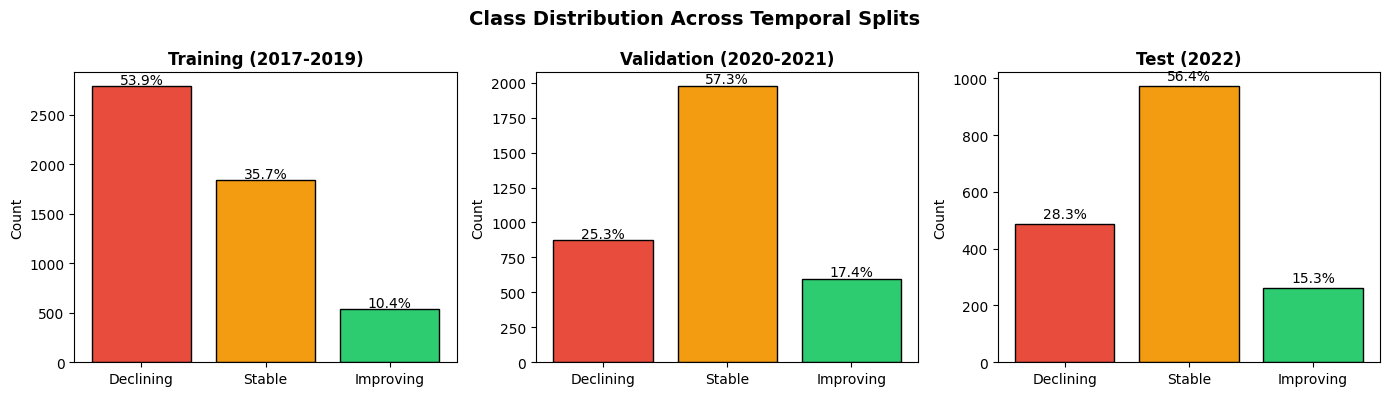


✅ Figure saved to ../reports/class_distribution_splits.png


In [12]:
# ============================================
# VISUALIZE CLASS DISTRIBUTION
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

splits = [('Training (2017-2019)', df_train), 
          ('Validation (2020-2021)', df_val), 
          ('Test (2022)', df_test)]

class_colors = {'Declining': '#e74c3c', 'Stable': '#f39c12', 'Improving': '#2ecc71'}

for ax, (name, df_split) in zip(axes, splits):
    counts = df_split['Target_Trajectory'].value_counts().reindex(['Declining', 'Stable', 'Improving'])
    colors = [class_colors[c] for c in counts.index]
    
    bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='black')
    
    # Add percentage labels
    total = counts.sum()
    for bar, count in zip(bars, counts.values):
        pct = count / total * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                f'{pct:.1f}%', ha='center', fontsize=10)
    
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_ylabel('Count')

plt.suptitle('Class Distribution Across Temporal Splits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/class_distribution_splits.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to ../reports/class_distribution_splits.png")

---
## 6. Save Splits

In [13]:
# ============================================
# SAVE SPLIT DATASETS
# ============================================

# Save training data
train_path = '../data/processed/train.csv'
df_train.to_csv(train_path, index=False)
print(f"✅ Saved training data to: {train_path}")

# Save validation data
val_path = '../data/processed/val.csv'
df_val.to_csv(val_path, index=False)
print(f"✅ Saved validation data to: {val_path}")

# Save test data
test_path = '../data/processed/test.csv'
df_test.to_csv(test_path, index=False)
print(f"✅ Saved test data to: {test_path}")

✅ Saved training data to: ../data/processed/train.csv
✅ Saved validation data to: ../data/processed/val.csv
✅ Saved test data to: ../data/processed/test.csv


---
## 7. Final Summary

In [14]:
# ============================================
# TEMPORAL SPLIT SUMMARY
# ============================================

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                       TEMPORAL SPLIT COMPLETE                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  TRAINING SET (train.csv):                                                   ║
║  ───────────────────────────                                                 ║
║  • Years: 2017, 2018, 2019                                                   ║
║  • Rows: {len(df_train):,}                                                          ║
║  • Purpose: Train models, learn patterns                                     ║
║                                                                              ║
║  VALIDATION SET (val.csv):                                                   ║
║  ────────────────────────────                                                ║
║  • Years: 2020, 2021                                                         ║
║  • Rows: {len(df_val):,}                                                          ║
║  • Purpose: Tune hyperparameters, early stopping                             ║
║                                                                              ║
║  TEST SET (test.csv):                                                        ║
║  ───────────────────────                                                     ║
║  • Year: 2022                                                                ║
║  • Rows: {len(df_test):,}                                                          ║
║  • Purpose: Final unbiased evaluation                                        ║
║  • NEVER touched during training/tuning                                      ║
║                                                                              ║
║  TEMPORAL INTEGRITY: ✅ VERIFIED                                             ║
║  • No overlapping rows between splits                                        ║
║  • Strict year boundaries maintained                                         ║
║  • Model cannot "see the future"                                             ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

NEXT STEP: Proceed to 06_Model_Training.ipynb
→ Train models on train.csv, tune with val.csv
"""

print(summary)


╔══════════════════════════════════════════════════════════════════════════════╗
║                       TEMPORAL SPLIT COMPLETE                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  TRAINING SET (train.csv):                                                   ║
║  ───────────────────────────                                                 ║
║  • Years: 2017, 2018, 2019                                                   ║
║  • Rows: 5,166                                                          ║
║  • Purpose: Train models, learn patterns                                     ║
║                                                                              ║
║  VALIDATION SET (val.csv):                                                   ║
║  ────────────────────────────                                                ║
║  • Years: 2020, 2021          

---
## ✅ Checkpoint Complete

We've created temporal splits:
1. **Training**: 2017-2019 (learn patterns)
2. **Validation**: 2020-2021 (tune hyperparameters)
3. **Test**: 2022 (final evaluation)

**Temporal integrity verified** — no data leakage possible.

**Next Notebook:** `06_Model_Training.ipynb`  
We'll train Logistic Regression, Random Forest, and XGBoost using SMOTE for class imbalance.